# Max Cut

### Definition

We are given an undirected graph with vertex set $V$ and edge set $E$. 

Our aim is to partition the graph into two subgraphs connected by the maximum number of edges.

### Applications

Max Cut is a ubiquitous problem in fields like Network Design, Statistical Physics, Very Large Scale Integration (VLSI), Circuit Layout Design, Data Clustering.

### Path to solving the problem

Max Cut is a maximization problem and its cost function can be cast to an Ising problem through its respective Hamiltonian (see the [Introduction](./introduction_combinatorial_optimization.ipynb) and a [reference](https://en.wikipedia.org/wiki/Maximum_cut#Theoretical_physics)),

$$ \displaystyle \large
H = \displaystyle \textstyle\sum\limits_{uv \in E} s_{u} s_{v}
$$

where $v, u \in V$ and $s_u$ is a spin variable, which is $1$ if vertex $u$ is in the one subgraph and $-1$ if it is in the other.

The QLM allows us to encode a problem in this Hamiltonian form by using the `MaxCut` class with some specified graph. We can then create a job from the problem and send it to a heuristic Simulated Quantum Annealer (SQA) wrapped inside a Quantum Processing Unit (QPU) like the rest of the QPUs on the QLM. The SQA will minimize the Hamiltonian, hence we find the best solution to our problem.

For a more detailed explanation and a step-by-step guidance, please follow the sections below.

### Quantum resources

To represent the problem as Ising the QLM would need $N$ spins for each graph vertex. 

# Example problem

Imagine we are given a tree graph with $30$ vertices and $29$ edges, as shown below (left). One may quickly figure that we can partition the graph into two subgraphs, connected by all the graph edges. To achieve this, we can simply colour the nodes on the even levels of the tree graph by one colour, and the nodes on the odd levels $-$ by the other (right).

<br><img src="./max_cut_example_solution.png" style="width: 900px"><br>

Let us now describe how one can reach this answer using tools from the QLM. 
Furthermore, the approach will be applicable to finding the Max Cut of any graph !

We will start by specifying the graph with the `networkx` library, which allows us to explore a huge variety of graphs.

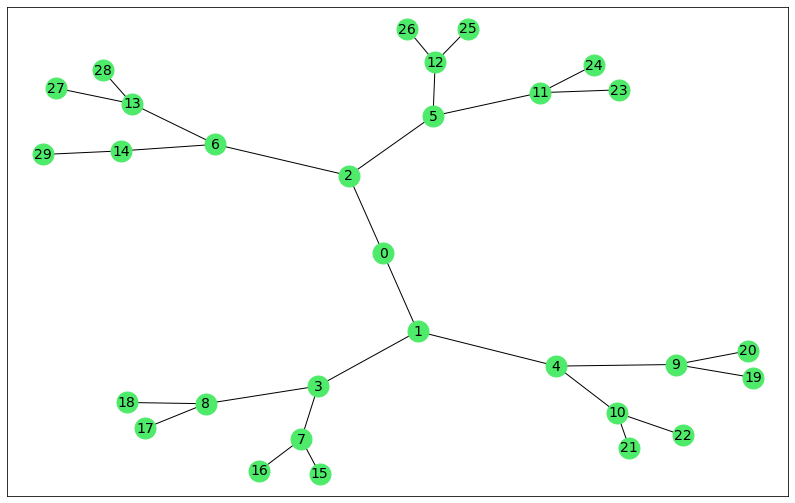

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Specify the graph 
graph = nx.full_rary_tree(2, 30)

# Draw the graph
nodes_positions = nx.spring_layout(graph, iterations=len(graph.nodes()) * 100)
plt.figure(figsize=(14, 9))
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 node_color='#4EEA6A', 
                 node_size=440, 
                 font_size=14)
plt.show()

The `MaxCut` class can now be called with this graph as input.

In [2]:
from qat.opt import MaxCut

max_cut_problem = MaxCut(graph)

# Solution

We can now proceed to compute the solution of the problem by following the steps:

1. Extract the best SQA parameters found for Max Cut by calling the method `get_best_parameters()`.

    The number of Monte Carlo updates is the total number of updates performed for each temperature (and gamma) on the spins of the equivalent 2D classical system. These updates are the product of the number of annealing steps $-$ `n_steps`, the number of "Trotter replicas" $-$ `n_trotters`, and the problem size, i.e. the number of qubits needed. Hence, we can use these parameters to get the best inferred value for `n_steps`. In general, the more these steps are, the finer and better the annealing will be. However this will cause the process to take longer to complete.
    
    Similarly for the `n_trotters` field in `SQAQPU` $-$ the higher it is, the better the final solution could be, but the more time taken by the annealer to reach an answer.


2. Create a temperature and a gamma schedule for the annealing.

    We use the extracted max and min temperatures and gammas to create a (linear) temperature and a (linear) gamma schedule. These schedules evolve in time from higher to lower values since we simulate the reduction of temperatures and magnetic fields. If one wishes to vary them it may help if the min values are close to $0$, as this will cause the Hamiltonian to reach a lower energy state, potentially closer to its ground state (where the solution is encoded).

    It should be noted that non-linear schedules may be investigated too, but for the same number of steps they could lead to a slower annealing. The best min and max values for gamma and the temperature were found for linear schedules.


3. Generate the SQAQPU and create a job for the problem. The job is then sent to the QPU and the annealing is performed.


4. Present the solution spin configuration.


5. Draw the respective nodes of each subgraph.

Each spin from the solution configuration corresponds to a node from the graph at the same position. Note that if the numbering of the input nodes starts from $1$ and not from $0$, one still needs to look at the $0$th spin to extract information for this first node, numbered as $1$.

When a spin has the value of $1$ or $-1$, this means that the respective node belongs to the one or the other subgraph. 

Solution configuration: 
[ 1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]

The nodes in the first subgraph:
[ 0  3  4  5  6 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]

The nodes in the second subgraph:
[ 1  2  7  8  9 10 11 12 13 14]


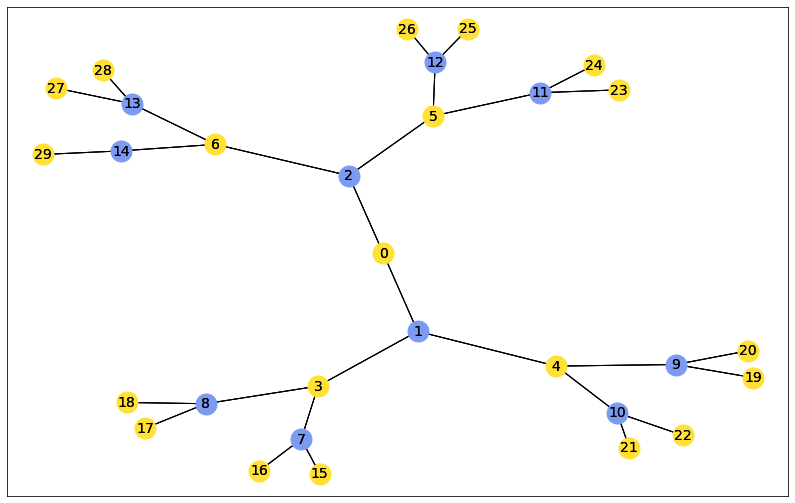

In [3]:
from qat.core import Variable
from qat.sqa import SQAQPU
from qat.sqa.sqa_qpu import integer_to_spins

# 1. Extract parameters for SQA
problem_parameters_dict = max_cut_problem.get_best_parameters()
n_monte_carlo_updates = problem_parameters_dict["n_monte_carlo_updates"]
n_trotters = problem_parameters_dict["n_trotters"]
n_steps = int(n_monte_carlo_updates /
              (n_trotters * len(graph.nodes()))) # the last one is the number of spins, i.e. the problem size
temp_max = problem_parameters_dict["temp_max"]
temp_min = problem_parameters_dict["temp_min"]
gamma_max = problem_parameters_dict["gamma_max"]
gamma_min = problem_parameters_dict["gamma_min"]

# 2. Create a temperature and a gamma schedule
tmax = 1.0
t = Variable("t", float)
temp_t = temp_min * (t / tmax) + temp_max * (1 - t / tmax)
gamma_t = gamma_min * (t / tmax) + gamma_max * (1 - t / tmax)

# 3. Create a job and send it to a QPU
problem_job = max_cut_problem.to_job(gamma_t=gamma_t, tmax=tmax, nbshots=1)
sqa_qpu = SQAQPU(temp_t=temp_t, n_steps=n_steps, n_trotters=n_trotters)
problem_result = sqa_qpu.submit(problem_job)

# 4. Extract and print solution configuration
state_int = problem_result.raw_data[0].state.int  # raw_data is a list of Samples - one per shot
solution_configuration = integer_to_spins(state_int, len(graph.nodes()))
print("Solution configuration: \n" + str(solution_configuration) + "\n")
indices_spin_1 = np.where(solution_configuration == 1)[0]
print("The nodes in the first subgraph:\n" + str(indices_spin_1) + "\n")
indices_spin_minus_1 = np.where(solution_configuration == -1)[0]
print("The nodes in the second subgraph:\n" + str(indices_spin_minus_1))


# 5. Draw the coloured subgraphs 
plt.figure(figsize=(14, 9))
node_size = 440
font_size = 14
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_1.tolist(), 
                 node_color='#FFE033', 
                 node_size=node_size, 
                 font_size=font_size)

nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_minus_1.tolist(), 
                 node_color='#7B9BF2', 
                 node_size=node_size, 
                 font_size=font_size)

nx.draw_networkx_edges(graph, pos=nodes_positions)
plt.show()

# Solution analysis

We are interested in how well the partitioning went. We know that for a tree, the number of connecting edges should be all edges. So we can compare this to the number of edges between the nodes we coloured.

In [4]:
number_of_edges_connecting_subgraphs = 0
for (u, v) in graph.edges():
    if solution_configuration[u] * solution_configuration[v] ==(-1):
        number_of_edges_connecting_subgraphs += 1

print("For a Max Cut partitioned tree graph the number of connecting edges is:")
print(len(graph.edges()))

print("Number of edges, which connect the two partitioned subgraphs:")
print(number_of_edges_connecting_subgraphs)

For a Max Cut partitioned tree graph the number of connecting edges is:
29
Number of edges, which connect the two partitioned subgraphs:
29
